In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


# from lightgbm import LGBMClassifier
import xgboost as xgb
# from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('modeling_data.csv') 
data.head()

,Unnamed: 0,CUSTOMER_ID,WINDOW_START_LOCAL,WINDOW_END_LOCAL,event_cutoff_by,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,...,mode_event_os,minutes_of_first_event_and_window_end,cutoff_amount,total_events,cart_page_views,product_page_views,order_page_views,visited_cart,visited_product,visited_order
0,0,500245685,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-23 11:02:29.219700000,G111,48 Hours,Monday,7,OFS,...,Windows,5924.706600,1777.411980,7,5,0,0,1,0,0
1,1,500245685,2025-03-17 17:00:00,2025-03-24 17:00:00,2025-03-22 19:49:23.863200000,G111,48 Hours,Monday,7,OFS,...,Windows,9034.144367,2710.243310,2,0,0,0,0,0,0
2,2,500245685,2025-04-14 17:00:00,2025-04-21 17:00:00,2025-04-20 11:20:52.683900000,G111,48 Hours,Monday,7,OFS,...,Windows,5927.056417,1778.116925,3,1,0,0,1,0,0
3,3,500245685,2025-04-28 17:00:00,2025-05-05 17:00:00,2025-05-04 18:24:35.996400000,G111,48 Hours,Monday,7,OFS,...,Windows,4507.125967,1352.137790,2,0,0,0,0,0,0
4,4,500245738,2024-11-20 17:00:00,2024-11-27 17:00:00,2024-11-26 03:25:05.337600000,G111,48 Hours,Wednesday,7,OFS,...,Windows,7515.126033,2254.537810,2,0,0,1,0,0,1


In [3]:
x = data.drop(columns=['ABANDONED_CART','CUSTOMER_ID'])
y = data['ABANDONED_CART']

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.3,
    random_state=12345,
    stratify=y 
)

# xgboost

In [8]:
# ==== PREP: make X strictly numeric (run after train_test_split) ====
import pandas as pd
import numpy as np

train = x_train.copy()
test  = x_test.copy()

# 1) Parse known datetime-like columns
dt_cols = [c for c in train.columns if c in [
    "WINDOW_START_LOCAL","WINDOW_END_LOCAL","EVENT_LOCAL_DT","EVENT_LOCAL_NAIVE"
]]
for c in dt_cols:
    train[c] = pd.to_datetime(train[c], errors="coerce")
    test[c]  = pd.to_datetime(test[c],  errors="coerce")

# 2) Add simple datetime features, then drop raw stamps
dt_use = train.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns
for c in dt_use:
    train[f"{c}_dow"]          = train[c].dt.dayofweek
    train[f"{c}_hour"]         = train[c].dt.hour
    train[f"{c}_month"]        = train[c].dt.month
    train[f"{c}_is_month_end"] = train[c].dt.is_month_end.astype("Int8")

    test[f"{c}_dow"]           = test[c].dt.dayofweek
    test[f"{c}_hour"]          = test[c].dt.hour
    test[f"{c}_month"]         = test[c].dt.month
    test[f"{c}_is_month_end"]  = test[c].dt.is_month_end.astype("Int8")

train = train.drop(columns=dt_use)
test  = test.drop(columns=dt_use)

# 3) Timedelta → seconds
td_cols = train.select_dtypes(include="timedelta64[ns]").columns
for c in td_cols:
    train[c] = pd.to_timedelta(train[c]).dt.total_seconds()
    test[c]  = pd.to_timedelta(test[c]).dt.total_seconds()

# 4) Booleans → ints
bool_cols = train.select_dtypes(include="bool").columns
for c in bool_cols:
    train[c] = train[c].astype("int8")
    test[c]  = test[c].astype("int8")

# 5) One-hot encode remaining object categoricals (the ones causing the crash)
obj_cols = train.select_dtypes(include="object").columns.tolist()
# (Your error listed these; keep them if present)
# ['event_cutoff_by','SALES_OFFICE','SHIPPING_CONDITIONS_DESC','WEEK_DAY_OF_ANCHOR_DATE',
#  'DISTRIBUTION_MODE_DESC','CUTOFFTIME__C','TIMEZONE','mode_event_dow','device_event_device',
#  'mode_event_mobile_brand','mode_event_os', ...]
train = pd.get_dummies(train, columns=obj_cols, drop_first=True)
# Some object cols may not exist in test; guard for that
test  = pd.get_dummies(test,  columns=[c for c in obj_cols if c in test.columns], drop_first=True)

# 6) Align columns and fill missing with 0
test = test.reindex(columns=train.columns, fill_value=0)

# 7) Median-impute any NaNs that slipped in
med = train.median(numeric_only=True)
train = train.fillna(med)
test  = test.fillna(med)

# (Optional sanity check)
#print("Any object dtypes left? train:", train.select_dtypes(include="object").columns.tolist())
#print("Any object dtypes left? test :", test.select_dtypes(include="object").columns.tolist())


Baseline Accuracy=0.853, Recall=0.633

Chosen threshold (recall-max, ≤5-pt acc drop): 0.420
Accuracy : 0.8067 (was 0.8526)
Precision: 0.4027
Recall   : 0.7224 (was 0.6332)
F1       : 0.5171

Confusion Matrix:
 [[3906  853]
 [ 221  575]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.82      0.88      4759
         1.0       0.40      0.72      0.52       796

    accuracy                           0.81      5555
   macro avg       0.67      0.77      0.70      5555
weighted avg       0.87      0.81      0.83      5555



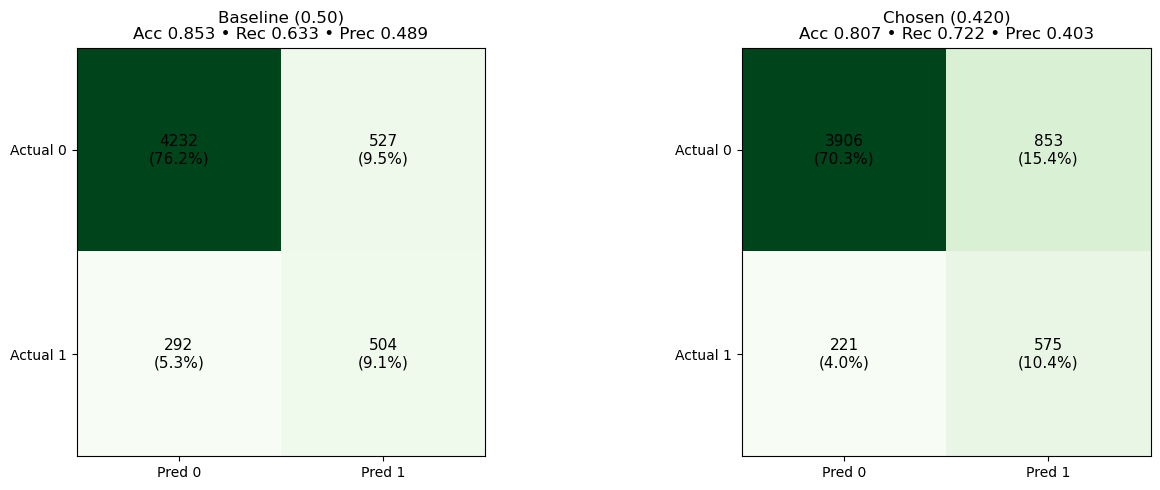

In [9]:
# === XGBoost model + recall-focused threshold (clean, complete) ===
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# 1️⃣ Split
x = data.drop(columns=['ABANDONED_CART','CUSTOMER_ID'])
y = data['ABANDONED_CART']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=12345, stratify=y
)

# 2️⃣ Clean objects
train, test = x_train.copy(), x_test.copy()
obj_cols = train.select_dtypes(include="object").columns
train = pd.get_dummies(train, columns=obj_cols, drop_first=True)
test = pd.get_dummies(test,  columns=[c for c in obj_cols if c in test.columns], drop_first=True)
test = test.reindex(columns=train.columns, fill_value=0)
train = train.fillna(train.median(numeric_only=True))
test  = test.fillna(train.median(numeric_only=True))

# 3️⃣ DMatrix + imbalance
dtrain = xgb.DMatrix(train, label=y_train)
dvalid = xgb.DMatrix(test,  label=y_test)
spw = (y_train==0).sum() / max((y_train==1).sum(), 1)

# 4️⃣ Train
params = {
    "objective": "binary:logistic", "eval_metric": "aucpr",
    "eta": 0.035, "max_depth": 6, "subsample": 0.9, "colsample_bytree": 0.9,
    "scale_pos_weight": spw, "tree_method": "hist", "seed": 42
}
early_cb = xgb.callback.EarlyStopping(rounds=80, save_best=True, metric_name="aucpr")
bst = xgb.train(params, dtrain, num_boost_round=2000,
                evals=[(dtrain,"train"),(dvalid,"valid")],
                callbacks=[early_cb], verbose_eval=False)

# 5️⃣ Predictions
best_iter = getattr(bst, "best_iteration", None)
y_prob = bst.predict(dvalid, iteration_range=(0, best_iter+1)) if best_iter else bst.predict(dvalid)
y_pred_050 = (y_prob >= 0.5).astype(int)

# 6️⃣ Baseline metrics
acc_050, prec_050, rec_050, f1_050 = (
    accuracy_score(y_test, y_pred_050),
    precision_score(y_test, y_pred_050),
    recall_score(y_test, y_pred_050),
    f1_score(y_test, y_pred_050)
)
print(f"Baseline Accuracy={acc_050:.3f}, Recall={rec_050:.3f}")

# 7️⃣ Recall-focused threshold (≤5-pt acc drop)
grid = np.linspace(0.05, 0.95, 181)
best_row = None
for th in grid:
    yp = (y_prob >= th).astype(int)
    acc = accuracy_score(y_test, yp)
    rec = recall_score(y_test, yp, zero_division=0)
    if acc >= acc_050 - 0.05:
        if best_row is None or rec > best_row["rec"]:
            best_row = {
                "th": th, "acc": acc, "rec": rec,
                "prec": precision_score(y_test, yp, zero_division=0),
                "f1": f1_score(y_test, yp, zero_division=0),
                "cm": confusion_matrix(y_test, yp)
            }

best_th, cm_best = best_row["th"], best_row["cm"]
print(f"\nChosen threshold (recall-max, ≤5-pt acc drop): {best_th:.3f}")
print(f"Accuracy : {best_row['acc']:.4f} (was {acc_050:.4f})")
print(f"Precision: {best_row['prec']:.4f}")
print(f"Recall   : {best_row['rec']:.4f} (was {rec_050:.4f})")
print(f"F1       : {best_row['f1']:.4f}")
print("\nConfusion Matrix:\n", cm_best)
print("\nClassification Report:\n",
      classification_report(y_test, (y_prob >= best_th).astype(int), zero_division=0))

# 8️⃣ Visualize confusion matrices
cm_050 = confusion_matrix(y_test, y_pred_050)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, cm, title, acc, rec, prec in [
    (axes[0], cm_050, "Baseline (0.50)", acc_050, rec_050, prec_050),
    (axes[1], cm_best, f"Chosen ({best_th:.3f})", best_row["acc"], best_row["rec"], best_row["prec"])
]:
    cm_prop = cm / cm.sum()
    ax.imshow(cm, cmap="Greens")
    ax.set_title(f"{title}\nAcc {acc:.3f} • Rec {rec:.3f} • Prec {prec:.3f}")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred 0","Pred 1"]); ax.set_yticklabels(["Actual 0","Actual 1"])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cm[i,j]}\n({cm_prop[i,j]:.1%})",
                    ha="center", va="center", fontsize=11)
plt.tight_layout()
plt.show()


